# <center>Supervised Learning</center>

## Данные

В рамках данной работы анализируется набор данных о студентах двух школ в Португалии.  
В файле `students_data.csv` представлена информация о студентах, посещающих два курса - математику (`Math`) и поргутальский язык (`Por`). Некоторые студенты представлены в обоих курсах, некоторые - только в одном. Для каждого студента известны три оценки по курсу: оценка за первое полугодие (`G1`), оценка за второе полугодие (`G2`) и итоговая оценка за год (`G3`).

In [6]:
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
import scipy.stats as stats

from sklearn.feature_selection import SelectPercentile, f_regression, chi2
from sklearn.metrics import r2_score, mean_absolute_error as mae, f1_score, roc_auc_score, \
                            precision_score, auc, roc_curve, recall_score, \
                            make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    RandomizedSearchCV, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier

In [7]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [8]:
pd.set_option('display.max_columns', 40)

pd.set_option('display.max_colwidth', None)

In [11]:
data = pd.read_csv("https://raw.githubusercontent.com/katearb/files/main/students_data.csv")

data.shape

(1044, 36)

## Часть 1. Предобработка данных

* Разделить данные на две части - данные для моделирования (80%) и отложенную выборку (20%). Убедиться, что распределение целевой переменной (`G3`) одинаково в обоих частях. 
* Выполнить необходимые преобразования данных: исправление ошибок, удаление выбросов и пропусков, приведение признаков к числовому виду.  
* Оценить значимость признаков для определения итоговой оценки за курс. Исключите из выборки незначимые признаки
* Feature engineering: создать новые признаки (значимые) на основе уже имеющихся.

### 1. Преобразование данных

In [7]:
cols = list(data.columns)[1:]

for col in cols:
    print(col, list(data[col].unique()))

Subject ['Por', 'Math']
school ['GP', 'MS']
sex ['F', 'M', 'm']
age [16, 17, 18, 15, 19, 21, 20, 22]
address ['U', 'R']
famsize ['GT3', 'LE3']
Pstatus ['A', 'T', 't']
Medu ['3', '1', '2', '4', '0', 'o']
Fedu ['4', '2', '3', '1', 'o', '0']
Mjob ['services', 'other', 'health', 'at_home', 'teacher', 'at-home']
Fjob ['other', 'services', 'health', 'at-home', 'teacher', 'at_home']
reason ['course', 'home', 'reputation', 'other']
guardian ['father', 'mother', 'other', 'futher']
traveltime [1, 2, 3, 4]
studytime [1, 2, 4, 3]
failures [0, 2, 1, 3]
schoolsup ['no', 'yes']
famsup ['no', 'yes']
paid ['no', 'yes']
activities ['no', 'yes']
nursery ['yes', 'no']
higher ['yes', 'no']
internet ['yes', 'no']
romantic ['no', nan, 'yes']
famrel [3.0, 5.0, 4.0, 1.0, 2.0, nan]
freetime [2, 3, 4, 1, 5]
goout [1, 4, 5, 3, 2]
Dalc [1.0, 3.0, 4.0, 2.0, 5.0, nan]
Walc [4.0, 3.0, 5.0, 1.0, 2.0, nan]
health [5, 3, 4, 2, 1]
absences [12, 2, 0, 4, 6, 10, 7, 20, 14, 11, 24, 8, 16, 21, 1, 18, 5, 22, 9, 3, 15, 26, 25,

In [8]:
# исправление ошибкок
data['sex'].replace(to_replace='m', value='M', inplace=True)
data['Pstatus'].replace(to_replace='t', value='T', inplace=True)
data['Mjob'].replace(to_replace='at-home', value='at_home', inplace=True)
data['Fjob'].replace(to_replace='at-home', value='at_home', inplace=True)
data['guardian'].replace(to_replace='futher', value='father', inplace=True)

data['Medu'] = data['Medu'].map({'1': 1, '2': 2, '3': 3, '4': 4, '0': 0, 'o': 0})
data['Fedu'] = data['Fedu'].map({'1': 1, '2': 2, '3': 3, '4': 4, '0': 0, 'o': 0})

In [9]:
# обнаружение пропущенных значений
nulls = data.isnull().sum()
nulls[nulls > 0]

romantic     10
famrel       10
Dalc         10
Walc         10
cheating    700
dtype: int64

In [10]:
# приведение данных к численным значениям
cat_columns = [ 'school', 'Subject', 'Mjob', 'Fjob', 'reason', 'guardian',
       'traveltime', 'studytime', 'failures', 'Subject', 'school']

for col in cat_columns:
    data[col] = data[col].astype('category')
    
binary_columns = ['schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in binary_columns:
    data[col] = data[col].map({'yes': 1, 'no': 0})

data['sex'] = data['sex'].map({'M': 1, 'F': 0})
data['address'] = data['address'].map({'U': 1, 'R': 0})
data['famsize'] = data['famsize'].map({'GT3': 1, 'LE3': 0})
data['Pstatus'] = data['Pstatus'].map({'T': 1, 'A': 0})
data['cheating'] = data['cheating'].map({'yes': 1, 'no': 0})
data['Subject'] = data['Subject'].map({'Por':1, 'Math':0})
data['school'] = data['school'].map({'GP':1, 'MS':0})

In [11]:
# приведение данных к чиловым значениям
numeric_data = data.copy()

categories = {'guardian': ['father', 'mother', 'other'],
              'Mjob': ['other', 'services', 'health', 'teacher', 'at_home'],
              'Fjob': ['other', 'services', 'health', 'teacher', 'at_home'],
              'reason': ['course', 'home', 'reputation', 'other'], 
              'Subject': ['Por', 'Math'],
               'school': ['GP', 'MS']}

for cat in categories:
    for ind, v in enumerate(categories[cat]):
        numeric_data[cat].replace(to_replace=v, value=ind, inplace=True)

numeric_data_dropna = numeric_data.dropna()

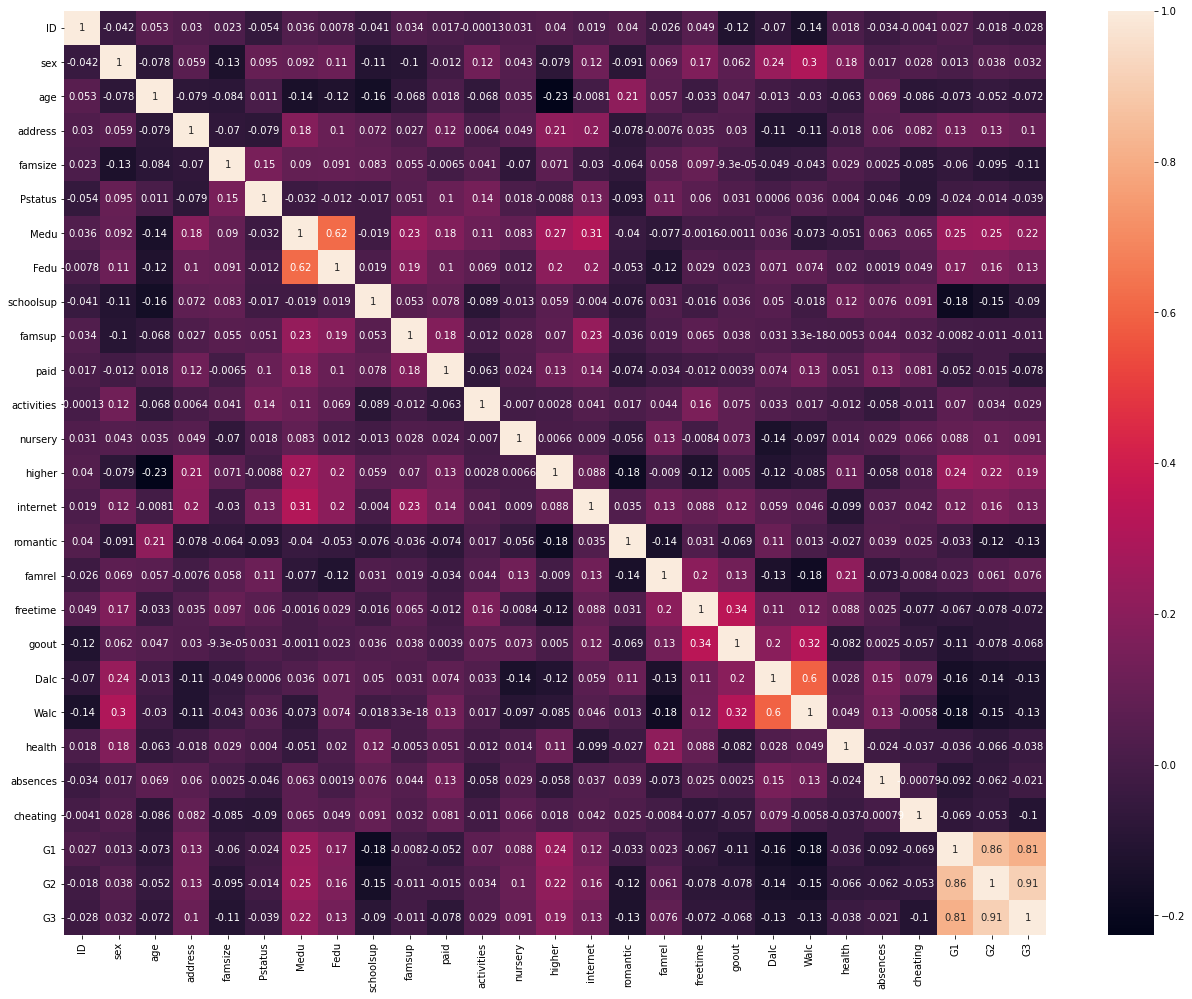

In [12]:
data_corr = numeric_data_dropna.corr()
plt.figure(figsize=(22, 17))
sns.heatmap(data_corr, annot=True)
plt.ylim((data_corr.shape[0], 0))

plt.show()

##### Комментарий
В таблице наблюдается корреляция между Dalc и Walc. Восстановим пропущенные значения в таблице в соответствии с этим, так как строки с пропущенными значениями в обоих колонках не пересекаются.

Удалим столбец cheating из-за большого количества пропусков.

In [13]:
# восстановление пропущенных значений в столбце walc, dalc
data_no_na = numeric_data.copy()
for i in data_no_na[data_no_na['Walc'].isnull()].index:
    data_no_na.at[i, 'Walc'] =  data_no_na.at[i, 'Dalc']
    
for i in data[data['Dalc'].isnull()].index:
    data_no_na.at[i, 'Dalc'] =  data_no_na.at[i, 'Walc']
    
data_no_na['Walc'] = data_no_na['Walc'].astype('int32')
data_no_na['Dalc'] = data_no_na['Dalc'].astype('int32')

Famrel находятся в небольшой зависимости с internet, Pstatus, nursery и в обратной зависимости с romantic.

In [14]:
# восстановление значений в столбце famrel
for i in data_no_na[data_no_na['famrel'].isnull()].index:
    row = data_no_na.iloc[i]
    if row['internet'] and row['Pstatus'] and row['nursery'] and not row['romantic']:
        data_no_na.at[i, 'famrel'] = 5
    elif row['internet'] or row['Pstatus'] or row['nursery'] or not row['romantic']:
         data_no_na.at[i, 'famrel'] = random.choice([3, 4])
    else:
        data_no_na.at[i, 'famrel'] = random.choice([1, 2])
        
data_no_na['famrel'] = data_no_na['famrel'].astype('int32')

In [15]:
data_no_na.drop(['ID', 'cheating'], axis=1, inplace=True)

In [16]:
# удаление строк с пропущенными значениями 
data_no_na.dropna(axis=0, inplace=True)
data_no_na.index = [i for i in range(len(data_no_na))]

In [17]:
data = data_no_na

### 2. Оценка значимости признаков  для определения итоговой оценки за курс. Исключение незначимых.

Здесь признаки подбираются отдельно для каждой задачи, поскольку важные признаки для них могут отличаться.

In [18]:
# выбор важных параметров для решения задачи регрессии
selector_reg = SelectPercentile(f_regression, percentile=80)
data_reg = selector_reg.fit_transform(data.drop('G3', axis=1), data['G3'])

mask_reg = selector_reg.get_support(indices=True)
new_columns_reg = data.drop('G3', axis=1).columns[mask_reg]

data_reg = pd.DataFrame(data=data_reg, columns=new_columns_reg)
data_reg['G3'] = data['G3']

In [19]:
# выбор важных параметров для решения задачи бинарной классификации
g3_binary_class = np.where(data['G3'] >= 8, 1, 0)

selector_binary_class = SelectPercentile(chi2, percentile=80)
data_binary_class = selector_binary_class.fit_transform(data.drop('G3', axis=1), g3_binary_class)

mask_binary_class = selector_binary_class.get_support()
new_columns_binary_class = data.drop('G3', axis=1).columns[mask_binary_class]

data_binary_class = pd.DataFrame(data=data_binary_class, columns=new_columns_binary_class)
data_binary_class['G3'] = g3_binary_class

In [20]:
# выбор важных параметров для решения задач множественной классификаци
g3_class = []
for i in range(len(data)):
    if data.at[i, 'G3'] in range(18, 21):
        g3_class.append(5)
    elif data.at[i, 'G3'] in range(14, 18):
        g3_class.append(4)
    elif data.at[i, 'G3'] in range(8, 14):
        g3_class.append(3)
    else:
        g3_class.append(2)

selector_class = SelectPercentile(chi2, percentile=80)
data_class = selector_class.fit_transform(data.drop('G3', axis=1), g3_class)

mask_class = selector_class.get_support()
new_columns_class = data.drop('G3', axis=1).columns[mask_class]

data_class = pd.DataFrame(data=data_class, columns=new_columns_class)
data_class['G3'] = g3_class

#### Комментарий: 
Я воспользовалась функцией SelectPercentile с percentile=80, чтобы убрать наименее значимые признаки и отсавить 27 столбцов. В данном методы, важность признаков оценивается по-разному в зависимомти от задачи: для регрессии используется параметр f_regression, для классификций -- chi2. Сама функция отбирает признаки, основываясь на p-значении.

### 3.Разделение данных на обучающую и проверочную части.

In [21]:
reg_training, reg_pending = train_test_split(data_reg, test_size=0.2)
binary_class_training, binary_class_pending = train_test_split(data_binary_class, test_size=0.2)
class_training, class_pending = train_test_split(data_class, test_size=0.2)

In [337]:
# проверка распределения признаков в обучающей и отложенной выборках
y_reg_training = reg_training['G3']
y_reg_pending = reg_pending['G3']

y_binary_class_training = binary_class_training['G3']
y_binary_class_pending = binary_class_pending['G3']

y_class_training = class_training['G3']
y_class_pending = class_pending['G3']

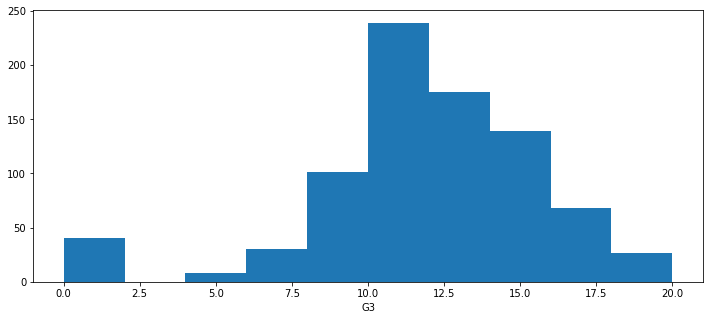

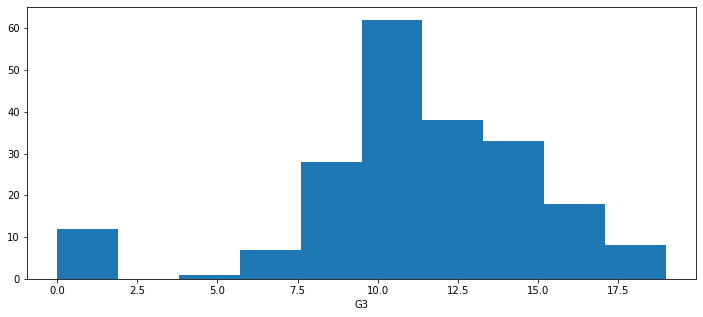

In [338]:
plt.hist(y_reg_training)
plt.xlabel('G3')
plt.show()

plt.hist(y_reg_pending)
plt.xlabel('G3')
plt.show()

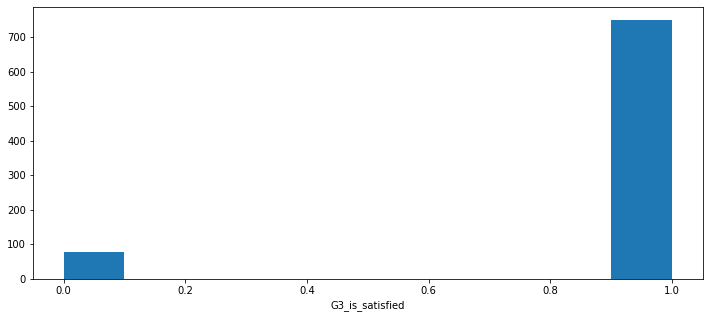

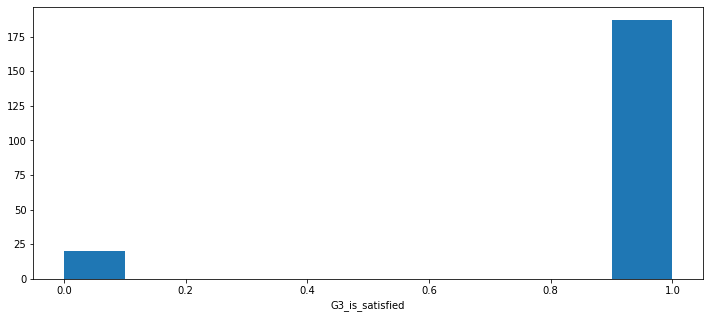

In [339]:
plt.hist(y_binary_class_training)
plt.xlabel('G3_is_satisfied')
plt.show()

plt.hist(y_binary_class_pending)
plt.xlabel('G3_is_satisfied')
plt.show()

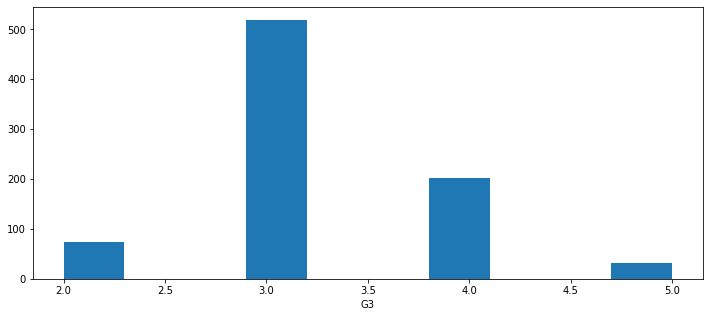

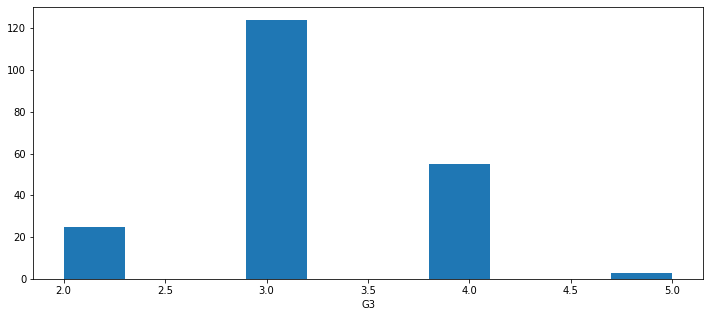

In [340]:
plt.hist(y_class_training)
plt.xlabel('G3')
plt.show()

plt.hist(y_class_pending)
plt.xlabel('G3')
plt.show()

## Часть 2. Регрессия

* Решить задачу регрессии: построить модель, предсказывающую итоговую оценку, которую получит студент по предмету (`G3`). При решении задачи **нельзя** использовать признак `G2`.  
<br>  
* Для решения задачи применить следующие методы:  
  * Линейная регрессия + регуляризации  
  * Полиномиальная регрессия  
  * KNN  
  * Деревья решений, Random Forest  
  
  Для каждого метода выполнить настройку гиперпараметров на кросс-валидации.  

<br>   

* Оценить качество каждой модели на отложенной выборке, используя различные метрики. Сравнить модели и сделайте вывод о качестве решения задачи.  
<br>    
* Задачу решить в двух вариантах: с использованием признака `G1`  и без него. Сравните качество решений в двух случаях.  
<br>    
* В регрессионных моделях дать интерпретацию весам признаков. 

### Обучение с использованием признака G1

In [341]:
X_reg_train = reg_training.drop(['G2', 'G3'], axis=1)
y_reg_train = reg_training['G3']

In [342]:
# linear regression
lin_reg = LinearRegression().fit(X_reg_train, y_reg_train)

#L1
lasso = Lasso()
lasso_param = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5]}
lasso_crossval = GridSearchCV(lasso, lasso_param).fit(X_reg_train, y_reg_train)
lasso = Lasso(**lasso_crossval.best_params_).fit(X_reg_train, y_reg_train)

#L2
ridge = Ridge()
ridge_param = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5]}
ridge_crossval = GridSearchCV(ridge, ridge_param).fit(X_reg_train, y_reg_train)
ridge = Ridge(**ridge_crossval.best_params_).fit(X_reg_train, y_reg_train)

In [343]:
# polynomial regression
param_grid = {'poly__degree': [2, 3]}
pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('lin', LinearRegression())])
polynom_crossval = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1).fit(X_reg_train, y_reg_train)

polynom_X = PolynomialFeatures(degree=polynom_crossval.best_params_['poly__degree']).fit_transform(X_reg_train)
pol_reg = LinearRegression().fit(polynom_X, y_reg_train)

In [344]:
# KNN regression
knn = KNeighborsRegressor()
knn_param = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3]}
knn_crossval = GridSearchCV(knn, knn_param).fit(X_reg_train, y_reg_train)
knn_reg = KNeighborsRegressor(**knn_crossval.best_params_).fit(X_reg_train, y_reg_train)

In [345]:
# RandomForest regression
forest = RandomForestRegressor()
forest_param = {'n_estimators': [3, 5, 8, 10, 20, 50, 100, 120],
               'criterion': ['mse', 'mae'],
               'max_depth': [None, 5, 10, 15],
               'min_samples_split': [2, 3, 5, 10],
               'min_samples_leaf': [1, 2, 3, 5, 6], 
               'max_features': ['auto', 'log', 'sqrt']}
forest_crossval = RandomizedSearchCV(forest, forest_param).fit(X_reg_train, y_reg_train)
forest_reg = RandomForestRegressor(**forest_crossval.best_params_).fit(X_reg_train, y_reg_train)

### Обучение без признака G1

In [346]:
X_reg_train_2 = reg_training.drop(['G1', 'G2', 'G3'], axis=1)

In [347]:
# linear regression
lin_reg_2 = LinearRegression().fit(X_reg_train_2, y_reg_train)

#L1
lasso_2 = Lasso()
lasso_param_2 = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5]}
lasso_crossval_2 = GridSearchCV(lasso_2, lasso_param_2).fit(X_reg_train_2, y_reg_train)
lasso_2 = Lasso(**lasso_crossval_2.best_params_).fit(X_reg_train_2, y_reg_train)

#L2
ridge_2 = Ridge()
ridge_param_2 = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5]}
ridge_crossval_2 = GridSearchCV(ridge_2, ridge_param_2).fit(X_reg_train_2, y_reg_train)
ridge_2 = Ridge(**ridge_crossval_2.best_params_).fit(X_reg_train_2, y_reg_train)

In [348]:
# polynomial regression
pipeline_2 = Pipeline(steps=[('poly', PolynomialFeatures()), ('lin', LinearRegression())])
polynom_crossval_2 = GridSearchCV(pipeline_2, param_grid, n_jobs=-1).fit(X_reg_train_2, y_reg_train)

polynom_X_2 = PolynomialFeatures(degree=polynom_crossval_2.best_params_['poly__degree']).fit_transform(X_reg_train_2)
pol_reg_2 = LinearRegression().fit(polynom_X_2, y_reg_train)

In [349]:
# KNN
knn_2 = KNeighborsRegressor()
knn_param_2 = {'n_neighbors': [3, 5, 7, 9, 11, 13], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3]}
knn_crossval_2 = GridSearchCV(knn_2, knn_param_2).fit(X_reg_train_2, y_reg_train)
knn_reg_2 = KNeighborsRegressor(**knn_crossval_2.best_params_).fit(X_reg_train_2, y_reg_train)

In [350]:
# Random Forest
forest_2 = RandomForestRegressor()
forest_crossval_2 = RandomizedSearchCV(forest_2, forest_param).fit(X_reg_train_2, y_reg_train)
forest_reg_2 = RandomForestRegressor(**forest_crossval_2.best_params_).fit(X_reg_train_2, y_reg_train)

In [351]:
# measuring: lin_reg lasso ridge pol_reg knn forest with G2
X_reg_pending = reg_pending.drop(['G2', 'G3'], axis=1)
y_reg_pending = reg_pending['G3']
X_reg_pending_poly = PolynomialFeatures(degree=polynom_crossval.best_params_['poly__degree']).fit_transform(X_reg_pending)

print('R2 score')
print('lin_reg:', r2_score(y_reg_pending, lin_reg.predict(X_reg_pending)))
print('lasso', r2_score(y_reg_pending, lasso.predict(X_reg_pending)))
print('ridge', r2_score(y_reg_pending, ridge.predict(X_reg_pending)))
print('pol_reg', r2_score(y_reg_pending, pol_reg.predict(X_reg_pending_poly)))
print('knn_reg', r2_score(y_reg_pending, knn_reg.predict(X_reg_pending)))
print('forest_reg', r2_score(y_reg_pending, forest_reg.predict(X_reg_pending)))

print('----')
print('MAE score')
print('lin_reg:', mae(y_reg_pending, lin_reg.predict(X_reg_pending)))
print('lasso:', mae(y_reg_pending, lasso.predict(X_reg_pending)))
print('ridge:', mae(y_reg_pending, ridge.predict(X_reg_pending)))
print('pol_reg:', mae(y_reg_pending, pol_reg.predict(X_reg_pending_poly)))
print('knn_reg:', mae(y_reg_pending, knn_reg.predict(X_reg_pending)))
print('forest_reg:', mae(y_reg_pending, forest_reg.predict(X_reg_pending)))


R2 score
lin_reg: 0.6599367050612661
lasso 0.6483474730565946
ridge 0.659280700388098
pol_reg 0.5387071238589852
knn_reg 0.6641667819519005
forest_reg 0.739996162319368
----
MAE score
lin_reg: 1.5691042977500207
lasso: 1.5517336349950994
ridge: 1.5676325098592747
pol_reg: 2.0387562512271646
knn_reg: 1.5833348274499557
forest_reg: 1.4498040791740592


In [352]:
# measuring: lin_reg lasso ridge pol_reg knn forest without G2
X_reg_pending_2 = reg_pending.drop(['G1', 'G3', 'G2'], axis=1)
X_reg_pending_poly_2 = PolynomialFeatures(degree=polynom_crossval_2.best_params_['poly__degree']).fit_transform(X_reg_pending_2)

print('Модели, обучившиеся без G1 признака\nR2 score')
print('lin_reg_2:', r2_score(y_reg_pending, lin_reg_2.predict(X_reg_pending_2)))
print('lasso_2', r2_score(y_reg_pending, lasso_2.predict(X_reg_pending_2)))
print('ridge_2', r2_score(y_reg_pending, ridge_2.predict(X_reg_pending_2)))
print('pol_reg_2', r2_score(y_reg_pending, pol_reg_2.predict(X_reg_pending_poly_2)))
print('knn_reg_2', r2_score(y_reg_pending, knn_reg_2.predict(X_reg_pending_2)))
print('forest_reg_2', r2_score(y_reg_pending, forest_reg_2.predict(X_reg_pending_2)))

print('----')
print('MAE score')
print('lin_reg_2:', mae(y_reg_pending, lin_reg_2.predict(X_reg_pending_2)))
print('lasso_2:', mae(y_reg_pending, lasso_2.predict(X_reg_pending_2)))
print('ridge_2:', mae(y_reg_pending, ridge_2.predict(X_reg_pending_2)))
print('pol_reg_2:', mae(y_reg_pending, pol_reg_2.predict(X_reg_pending_poly_2)))
print('knn_reg_2:', mae(y_reg_pending, knn_reg_2.predict(X_reg_pending_2)))
print('forest_reg_2:', mae(y_reg_pending, forest_reg_2.predict(X_reg_pending_2)))


Модели, обучившиеся без G1 признака
R2 score
lin_reg_2: 0.19927975962524425
lasso_2 0.19802122453445115
ridge_2 0.20004657213807497
pol_reg_2 -0.01235147887040089
knn_reg_2 0.12358927325385394
forest_reg_2 0.25383185195205804
----
MAE score
lin_reg_2: 2.6043028057555686
lasso_2: 2.6029250178106156
ridge_2: 2.6022256502464143
pol_reg_2: 2.9826701462110257
knn_reg_2: 2.6366970007526565
forest_reg_2: 2.434760887006337


### Вывод

1. Признак G1 оказывает большое влияние на качестов модели, поскольку они находятся в линейной зависимости.
2. Хуже всего справляется полиномиальная регрессия в обоих случаях.
3. Лучше всего RandomForest, однако коэфициент детерминации все равно невысок.
4. Показатели всех моделей находятся на примерно одном уровне: средний коэф. детерминации ~ 0.2, средняя абсолютная ошибка --  2.5.

Про веса признаков: Веса признаков имеют примерно одинаковые значения в линейной и Ridge моделях и не отличаются более чем на сотые доли, в то время как Lasso в среднем имеет более маленькие веса (кроме признака G1) и многие признаки вовсе зануляет.


In [353]:
# веса признаков
pd.DataFrame([lin_reg.coef_, lasso.coef_, ridge.coef_], columns=X_reg_train.columns, index=['Linear', 'Lasso', 'Ridge'])

,Subject,school,age,address,famsize,Medu,Fedu,reason,guardian,traveltime,studytime,failures,schoolsup,paid,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1
Linear,1.154684,-0.185410,-0.027274,0.221584,-0.075291,0.132516,-0.094519,-0.071649,0.143583,0.043357,-0.045115,-0.479659,0.221548,0.244448,0.125479,0.086501,-0.418835,0.171610,0.021137,-0.113189,-0.152871,0.129231,-0.088020,0.035067,0.978401
Lasso,0.596335,-0.000000,-0.010375,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.316409,0.000000,0.000000,0.000000,0.000000,-0.002159,0.042695,-0.000000,-0.000000,-0.000000,0.000000,-0.035705,0.019797,0.993301
Ridge,1.113195,-0.180298,-0.029429,0.211982,-0.075339,0.131396,-0.093066,-0.070856,0.139918,0.041993,-0.044430,-0.476800,0.205446,0.216103,0.118222,0.082960,-0.407192,0.170980,0.019263,-0.110576,-0.149151,0.126691,-0.088003,0.034503,0.978261


## Часть 3. Бинарная классификация

Решить задачу бинарной классификации: построить модель, предсказывающую, сдаст студент предмет (`G3` >= 8) или не сдаст (`G3` < 8). <br>При решении задачи **нельзя** использовать признаки `G1` и `G2`.  


### Задание 1  
  
* Построить дерево решений глубины 5 (остальные параметры по умолчанию), оценить качество на 5-fold валидации.  
* Для одного из деревьев (т.е. обученного на одной из итераций кросс-валидации) вывести само дерево - построить график или вывести в текстовом виде. По структуре дерева сформулировать правила, по которым принимается решение. 

* Сравнить между собой деревья решений, полученных на различных итерациях 5-fold валидации. Сделать вывод, насколько сильно они похожи или различаются между собой. 

In [354]:
X_bin_class_train = binary_class_training.drop(['G1', 'G3', 'G2'], axis=1)
y_bin_class_train = binary_class_training['G3']

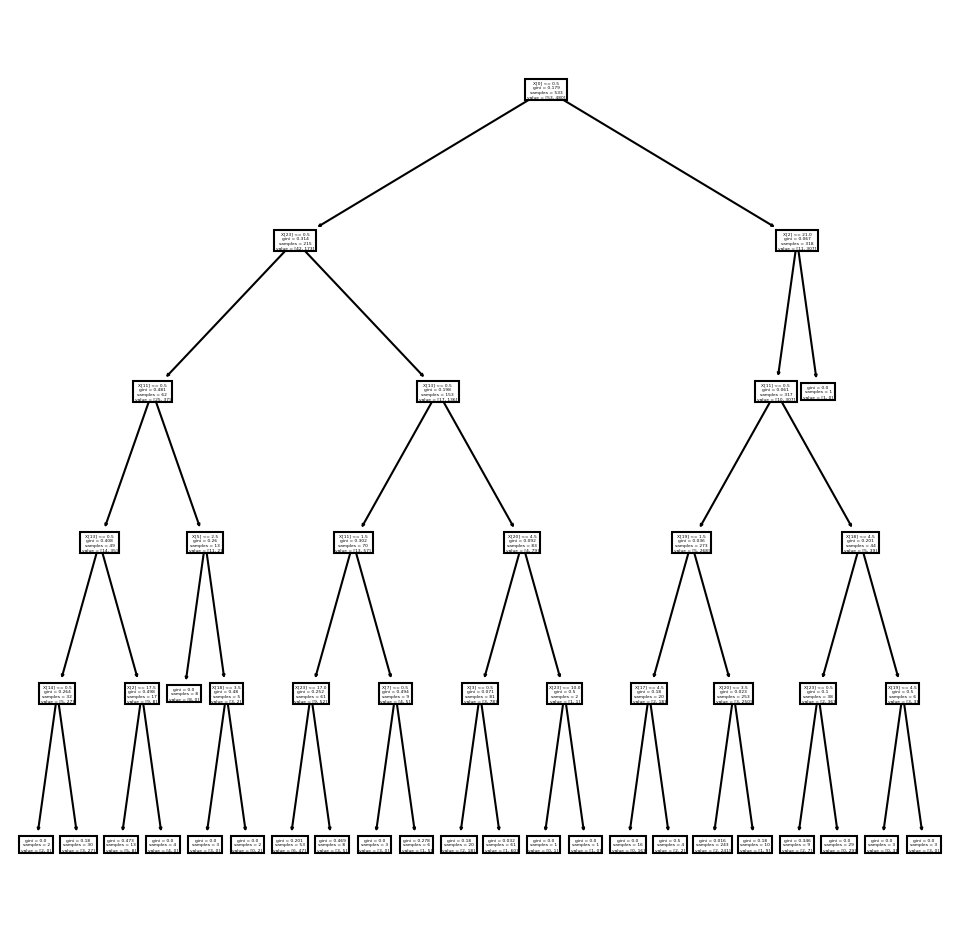

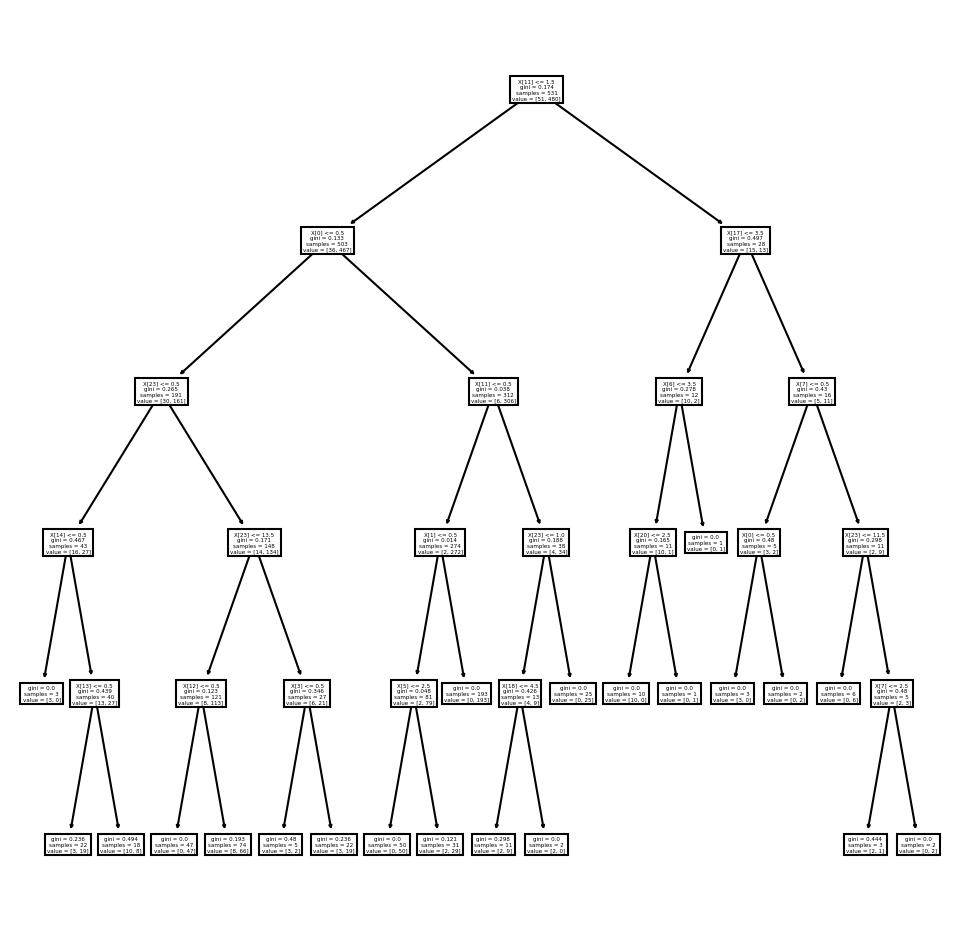

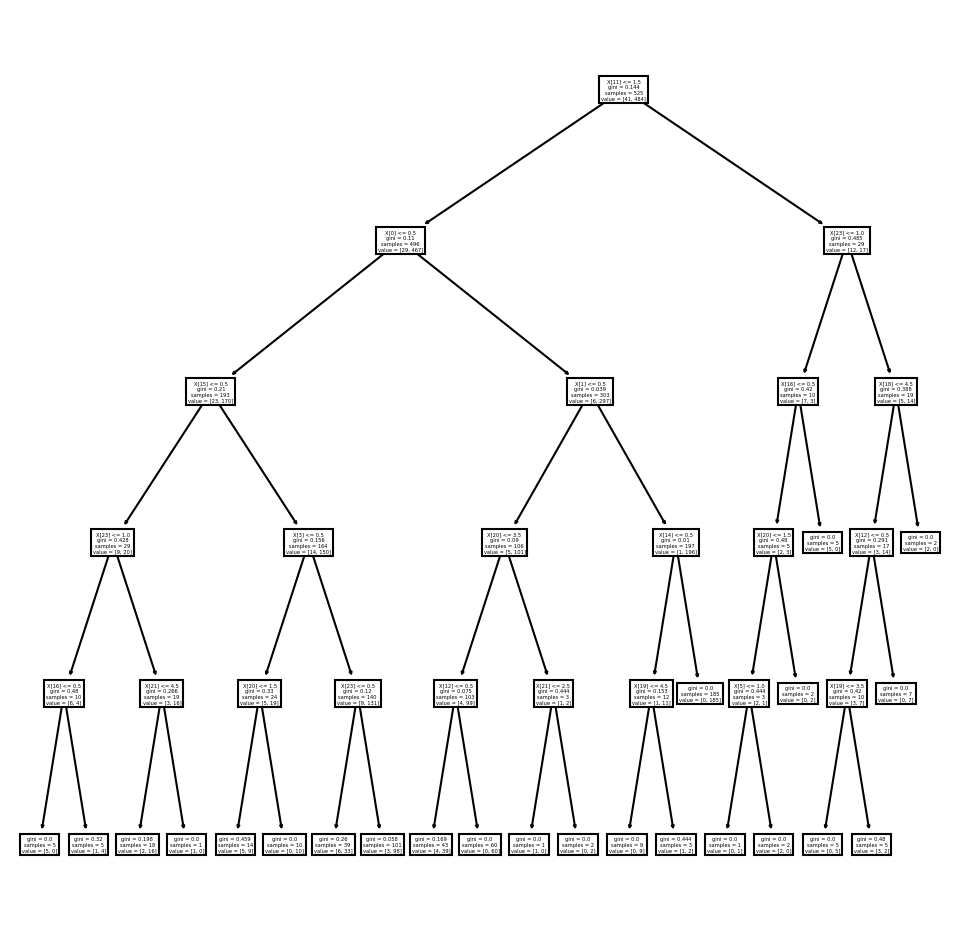

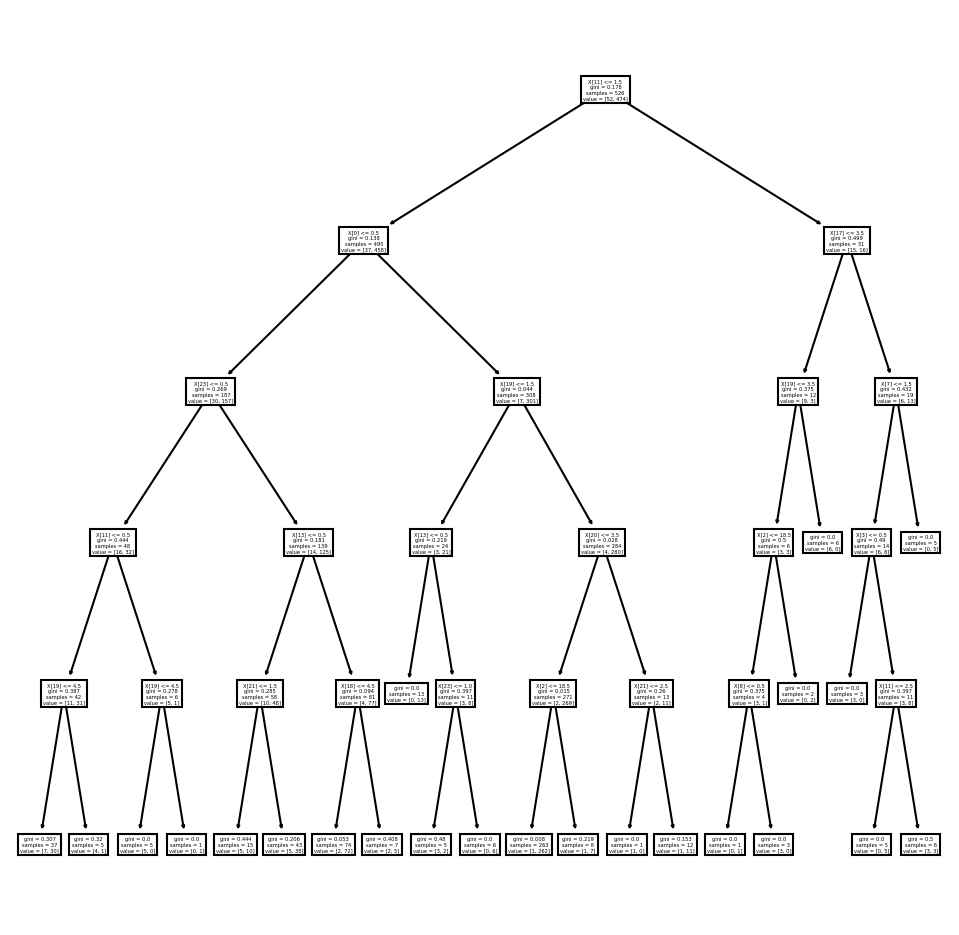

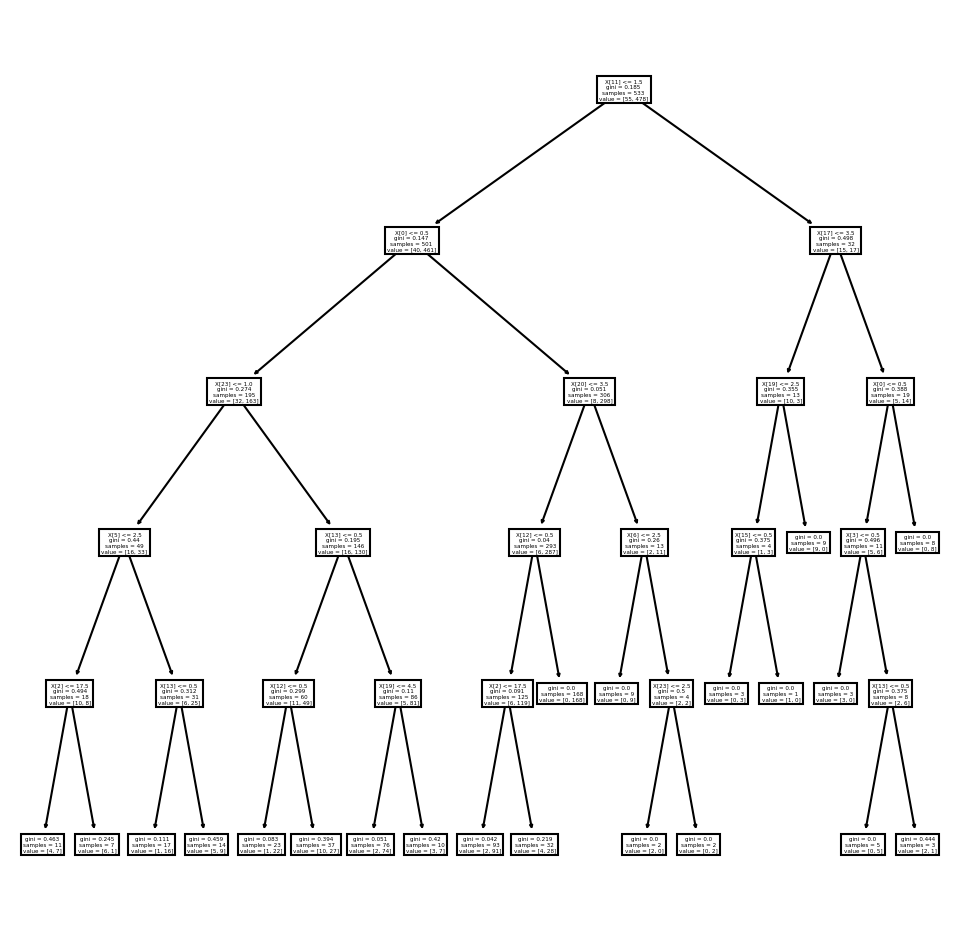

In [355]:
kf = KFold(n_splits=5)
tree_clf = DecisionTreeClassifier(max_depth=5)

for train, test in kf.split(X_bin_class_train):
    X_train, X_test = X_bin_class_train[X_bin_class_train.index.isin(train)], X_bin_class_train[X_bin_class_train.index.isin(test)]
    y_train, y_test = y_bin_class_train[y_bin_class_train.index.isin(train)], y_bin_class_train[y_bin_class_train.index.isin(test)]
    
    tree_clf.fit(X_train, y_train)
    
    figure(figsize=(8, 8), dpi=150)
    plot_tree(tree_clf)
    plt.show()

### Сравнение деревьев на каждой итерации
1. Самое простое дерево было построено на последней итерации.
2. Мы можем наблюдать, как дерево то усложняется, то упрощается (незначительно) на разных итерациях.
3. При этом, меняются и сами правила.

#### Описание общих правил дерева (на последней итерации):
Наиболее вероятные условия для отнесения студента к двочникам:
1. если у студента больше одного завала (failures), плохие отношения в семье (famrel) и студент много проводит времени гуляя
2. если у студента 1 или 0 завалов, предмет -- математика, а возраст больше 17 лет.

Для отнесения студента к успевающим:
1. предмет -- Португальский, оценка уровня употребления алкоголя по будням <=3.5 и есть внеклассная помощь по учебе (schoolsup).
2. предмет -- математика, посещение платных доп. занятий и оценка уровня провождения времени с друзьями <= 4.
3. Предмет -- математика, отсутствие платных доп. занятий и наличие помощи в учебе.

При остальных условиях наблюдается большой коэф. Джини, что говорит о нечетких различиях между представителями данных классов.

### Задание 2  
  
На кросс-валидации (5-fold из 2 повторений) оценить, как меняется качество модели Random Forest с ростом числа деревьев (при дефолтных значениях остальных параметров). Провизуализировать результаты. Сколько деревьев достаточно в данном случае и почему? 

**NB:** В сравнение включить конфигурацию, аналогичную простому дереву решений. 

In [356]:
X_binary_class_pending = binary_class_pending.drop(['G1', 'G2', 'G3'], axis=1)

In [357]:
n_trees = [1, 3, 5, 8, 10, 20, 50, 100, 125, 150, 200]
f1_scores, roc_auc_scores, precision_scores, recall_scores = [], [], [], []

for n in n_trees:
    forest_biclass = RandomForestClassifier(n_estimators=n)
    
    for i in range(2):
        for train, test in kf.split(X_bin_class_train):
            X_train, X_test = X_bin_class_train[X_bin_class_train.index.isin(train)], X_bin_class_train[X_bin_class_train.index.isin(test)]
            y_train, y_test = y_bin_class_train[y_bin_class_train.index.isin(train)], y_bin_class_train[y_bin_class_train.index.isin(test)]
            forest_biclass.fit(X_train, y_train)
            
    f1_scores.append(f1_score(y_binary_class_pending, forest_biclass.predict(X_binary_class_pending)))
    roc_auc_scores.append(roc_auc_score(y_binary_class_pending, forest_biclass.predict(X_binary_class_pending)))
    precision_scores.append(precision_score(y_binary_class_pending, forest_biclass.predict(X_binary_class_pending)))
    recall_scores.append(recall_score(y_binary_class_pending, forest_biclass.predict(X_binary_class_pending)))


In [359]:
def show_scores(n_trees, scores, title_info): 
  plt.figure(figsize=(15, 5))
  plt.xticks(n_trees)
  plt.xlabel('number of trees')
  plt.ylabel('score')
  plt.plot(n_trees, scores) 
  plt.title(title_info) 
  plt.show()

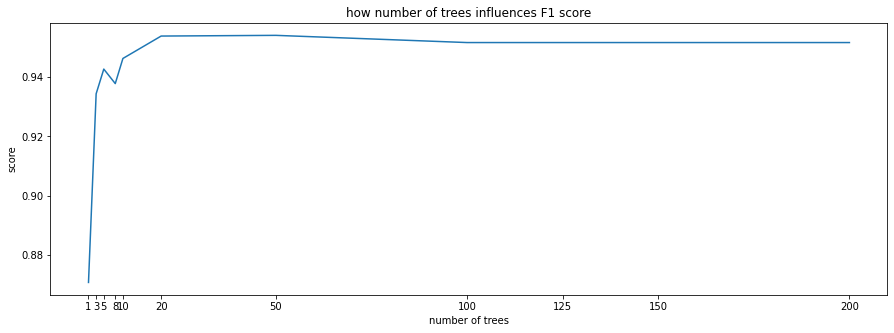

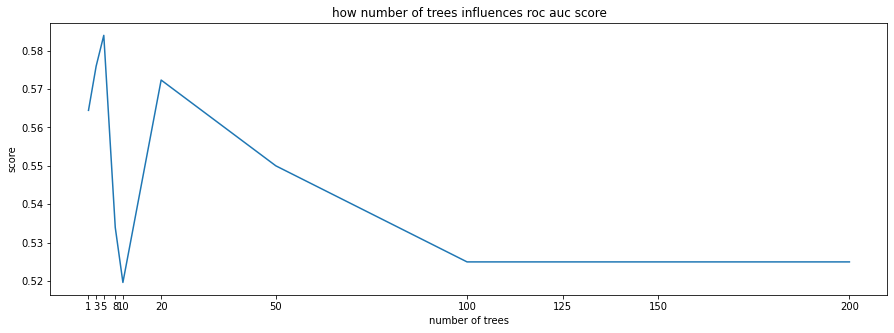

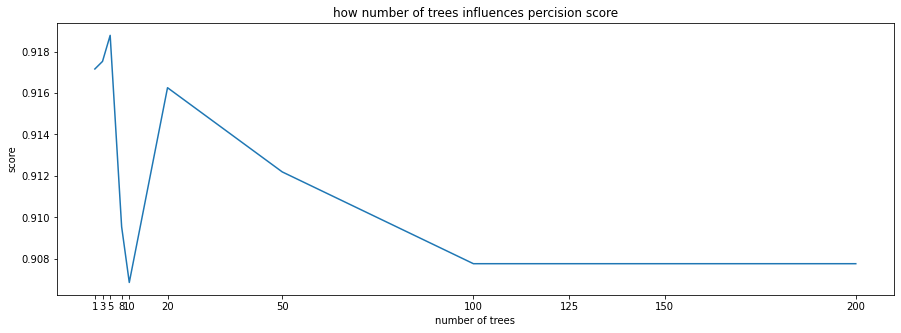

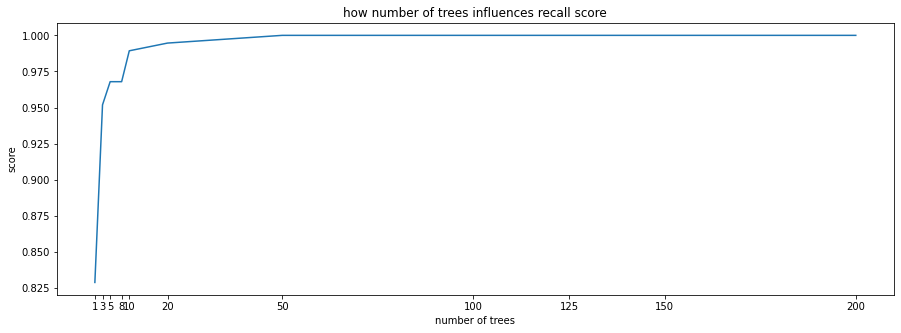

In [360]:
show_scores(n_trees, f1_scores, 'how number of trees influences F1 score')

show_scores(n_trees, roc_auc_scores, 'how number of trees influences roc auc score')

show_scores(n_trees, precision_scores, 'how number of trees influences percision score')

show_scores(n_trees, recall_scores, 'how number of trees influences recall score')

# Вывод:
Cудя по графикам различных метрик, самым оптимальным вариантом в данном случае является количество деревьев = 5: f1-score УЖЕ досаточно велик, а roc auc ЕЩЕ достаточно велик.


### Задание 3  
  
* Настройте гиперпараметры модели Random Forest на 5-fold валдиации. В качестве метрики используйте F1-score. Замерьте время, затраченное на вычисления.
* Обучите Random Forest  с настроенными параметрами на всех данных для моделирования. На отложенной выборке оцените качество (F1-score) всего ансамбля и <u>каждого дерева отдельно</u>. Постройте график распределения качества деревьев в ансамбле и сравните результаты с качеством всего леса. Дайте комментарий.  


* Выведите важность признаков в Random Forest, сделайте выводы. 

In [361]:
forest_biclass = RandomForestClassifier()
forest_biclass_param = {'n_estimators': [3, 5, 8, 10, 20, 50, 100, 120],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 5, 10, 15],
               'min_samples_split': [2, 3, 5],
               'min_samples_leaf': [1, 2, 3, 6], 
               'max_features': ['auto', 'log2', 'sqrt']}
f1_scorer = make_scorer(f1_score)
forest_biclass_crossval = RandomizedSearchCV(forest_biclass, forest_biclass_param, cv=5, scoring=f1_scorer, verbose=1).fit(X_bin_class_train, y_bin_class_train)
forest_biclass = RandomForestClassifier(**forest_biclass_crossval.best_params_).fit(X_bin_class_train, y_bin_class_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.5s finished


In [362]:
X_bin_class_pending = binary_class_pending.drop(['G1', 'G2', 'G3'], axis=1)
y_bin_class_pending = binary_class_pending['G3']

In [363]:
f1_forest_class = f1_score(y_bin_class_pending, forest_biclass.predict(X_bin_class_pending))
f1_each_tree = []
for estimator in forest_biclass.estimators_:
    f1_each_tree.append(f1_score(y_bin_class_pending, estimator.predict(X_bin_class_pending)))

Text(0.5, 1.0, 'Распределение качества деревьев в ансамбле ')

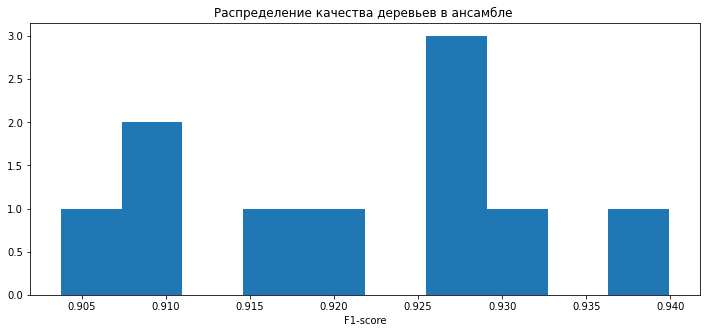

In [364]:
plt.hist(f1_each_tree)
plt.xlabel('F1-score')
plt.title('Распределение качества деревьев в ансамбле ')

In [392]:
f1_score(y_bin_class_pending, forest_biclass.predict(X_bin_class_pending))

0.9465648854961831

### Коммментарий к распределению ошибок деревьев и ансамбля:
Все значения качества отдельных деревьев раполагаются ниже, чем качесво итогового ансамбля, то есть итоговый результат лучше результата любого отдельно взятого дерева.

In [365]:
# важные признаки
feature_imp = pd.Series(forest_biclass.feature_importances_,index=X_bin_class_train.columns).sort_values(ascending=False)

In [366]:
feature_imp

absences      0.143042
failures      0.125385
Subject       0.085360
goout         0.068629
health        0.054284
age           0.051945
Mjob          0.043667
Medu          0.042022
famrel        0.039893
freetime      0.039344
address       0.039128
Fedu          0.037507
famsup        0.037107
Walc          0.035746
Dalc          0.029097
higher        0.021114
studytime     0.019162
internet      0.017240
traveltime    0.016220
guardian      0.013725
activities    0.013490
romantic      0.011621
school        0.008947
famsize       0.006325
dtype: float64

Выводы: 
1. наиболее важными оказались метрики, напрямую связанные с учебой и успеваемостью: количество отсутствий и количество пересдач (что довольно очевидно).
2. Преподаваемый предмет тоже важен -- видимо, по олному из них средняя оценка выше среди всех студентов.
3. Также важную роль играет количество свободного времени (что, соответвенно, определяет количество времени, затраченного на учебу): больше потратил времени -- выше оценка.
4. фактор здоровья тоже имеет место. Вероятно, он взаимосвязан с признаком absences (пропуски по болезни).
5. фактор возраста: люди более старшего возраста стараются получить более выскокие оценки, чтобы получить хороший аттестат.
6. роль матери в учебе ребенка: образование и работа матери влияют на успеваемость ребенка, что неудивительно, поскольку матери более вовлечены в воспитание ребенка, чем отцы.

### Задание 4  
  
* Применить логистическую регрессию для решения задачи, подобрать оптимальные значения гиперпараметров. Оценить качество (roc auc) на 5-fold валидации из 2 повторений. 
* Аналогично (на такой же валидации (тех же подвыборках) с такой же метрикой) оценить качество Random Forest  с подобранными в предыдущем задании параметрами. Сравнить с качеством логистическом регрессии.
* Обучить логистическую модель с настроенными параметрами на всех данных для моделирования. На отложенной выборке оценить качество - построить ROC-кривую, вычислите roc auc. Вычислить аналогичную метрику для Random Forest из Задания 3, сравнить точность моделей. 

In [367]:
log_class = LogisticRegression()
log_class_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

roc_auc_scorer = make_scorer(roc_auc_score)

log_class_crossval = GridSearchCV(log_class, log_class_param, cv=5, scoring=roc_auc_scorer).fit(X_bin_class_train, y_bin_class_train)
log_class = LogisticRegression(**log_class_crossval.best_params_).fit(X_bin_class_train, y_bin_class_train)

In [368]:
cross_val_score_forest = cross_val_score(forest_biclass, X_bin_class_pending, y_bin_class_pending, scoring=roc_auc_scorer, cv=5)
cross_val_score_log = cross_val_score(log_class, X_bin_class_pending, y_bin_class_pending, scoring=roc_auc_scorer, cv=5)

In [369]:
def show_rocauc(model):
    probs = model.predict_proba(X_bin_class_pending)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_bin_class_pending, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

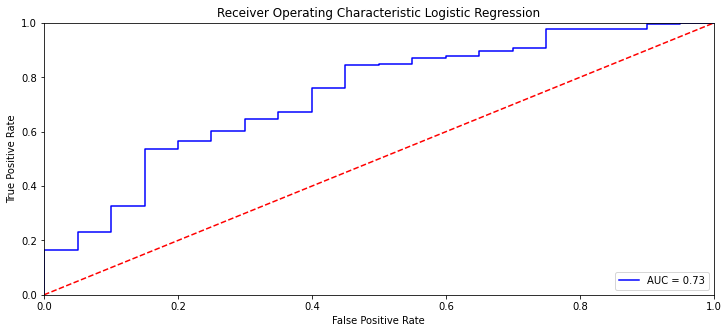

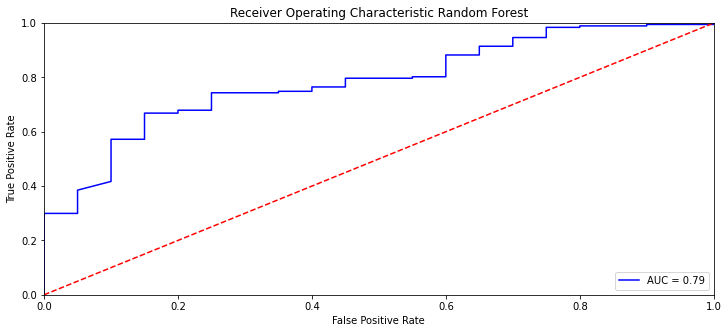

In [370]:
# roc auc plot

plt.title('Receiver Operating Characteristic Logistic Regression')
show_rocauc(log_class)

plt.title('Receiver Operating Characteristic Random Forest')
show_rocauc(forest_biclass)

#### Сравнение:
RandomForest имеет более хороший результат, хотя отрыв от логистической регрессии не велик (0.06)

### Задание 5  
  
* Использовать для решения задачи один из фреймворков градиентного бустинга: CatBoost.  
* Оценить на 5-fold валидации, как растет качество модели на обучающей и на тестовой выборках при добавлении каждого дерева. Провизуализируйть результаты.  
* Настроить гиперпараметры модели на 5-fold валидации, в качестве метрики используйте F1-score. Замерить время, затраченное на вычисления.  
* Обучить модель с настроенными параметрами на всех данных для моделирования и оцените качество на отложенной выборке. Сравнить результаты с другими моделями.

In [373]:
cat_model = CatBoostClassifier()

for train, test in kf.split(X_bin_class_train):
    X_train, X_test = X_bin_class_train[X_bin_class_train.index.isin(train)], X_bin_class_train[X_bin_class_train.index.isin(test)]
    y_train, y_test = y_bin_class_train[y_bin_class_train.index.isin(train)], y_bin_class_train[y_bin_class_train.index.isin(test)]
    cat_model.fit(X_train, y_train, verbose=False, eval_set=(X_bin_class_pending, y_bin_class_pending))

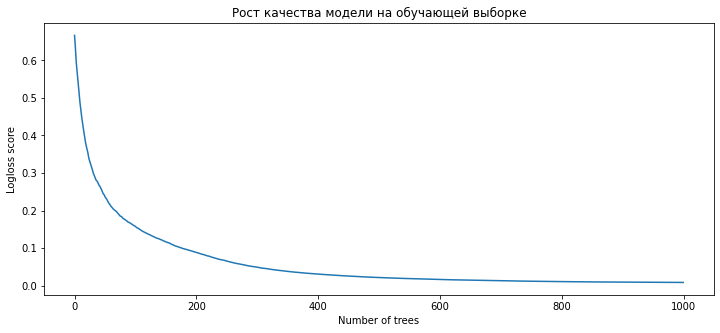

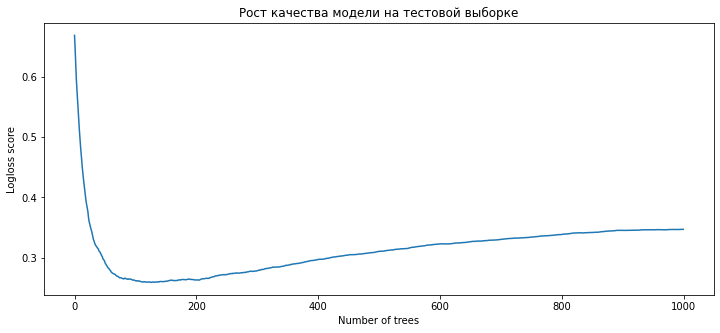

In [374]:
plt.plot(cat_model.evals_result_['learn']['Logloss'])
plt.ylabel('Logloss score')
plt.xlabel('Number of trees')
plt.title('Рост качества модели на обучающей выборке')
plt.show()

plt.plot(cat_model.evals_result_['validation']['Logloss'])
plt.ylabel('Logloss score')
plt.xlabel('Number of trees')
plt.title('Рост качества модели на тестовой выборке')
plt.show()

In [376]:
# настройка гиперпараметров

cat_model = CatBoostClassifier()

cat_param = {'iterations': [5, 20, 70, 100, 200, 500],
            'eta': [0.001, 0.01, 0.5, 1],
            'bootstrap_type': ['Bayesian', 'MVS', 'Bernoulli'],
            'depth': [5, 7, 10], 
            'min_data_in_leaf': [1, 2, 5, 10],
            }
cat_model_crossval = RandomizedSearchCV(cat_model, cat_param, cv=5, scoring=f1_scorer, verbose=0).fit(X_bin_class_train, y_bin_class_train)
cat_class = CatBoostClassifier(**cat_model_crossval.best_params_).fit(X_bin_class_train, y_bin_class_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Выходные данные были обрезаны до нескольких последних строк (5000).
55:	learn: 0.3517779	total: 120ms	remaining: 30.1ms
56:	learn: 0.3492579	total: 122ms	remaining: 27.9ms
57:	learn: 0.3461251	total: 125ms	remaining: 25.8ms
58:	learn: 0.3430604	total: 126ms	remaining: 23.6ms
59:	learn: 0.3404268	total: 128ms	remaining: 21.4ms
60:	learn: 0.3381914	total: 130ms	remaining: 19.1ms
61:	learn: 0.3348602	total: 132ms	remaining: 17ms
62:	learn: 0.3322238	total: 134ms	remaining: 14.9ms
63:	learn: 0.3286131	total: 136ms	remaining: 12.8ms
64:	learn: 0.3262326	total: 139ms	remaining: 10.7ms
65:	learn: 0.3232793	total: 141ms	remaining: 8.53ms
66:	learn: 0.3208986	total: 143ms	remaining: 6.4ms
67:	learn: 0.3179464	total: 145ms	remaining: 4.27ms
68:	learn: 0.3152714	total: 147ms	remaining: 2.13ms
69:	learn: 0.3121610	total: 150ms	remaining: 0us
0:	learn: 0.6822248	total: 2.16ms	remaining: 149ms
1:	learn: 0.6709381	total: 4.85ms	remaining: 165ms
2:	learn: 0.6598285	total: 7.21ms	remaining: 161ms
3:	le

In [377]:
cat_model_crossval.best_params_

{'bootstrap_type': 'Bayesian',
 'depth': 10,
 'eta': 0.5,
 'iterations': 200,
 'min_data_in_leaf': 5}

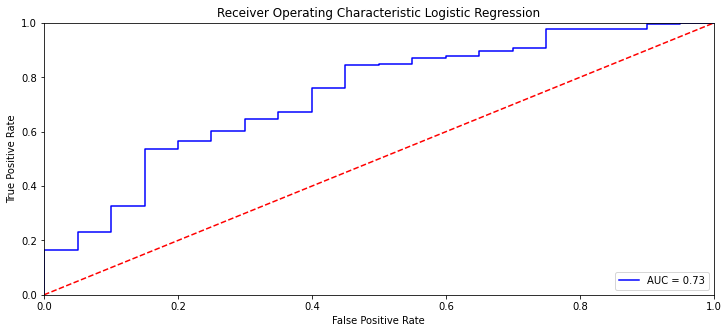

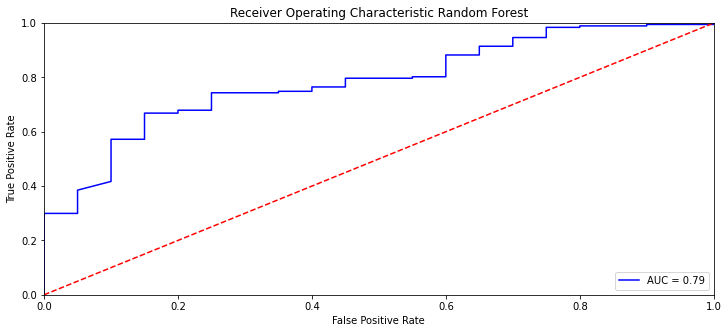

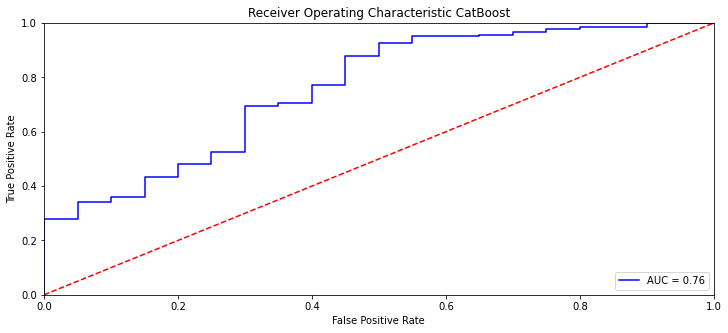

In [378]:
# сравнение моделей: roc auc

plt.title('Receiver Operating Characteristic Logistic Regression')
show_rocauc(log_class)

plt.title('Receiver Operating Characteristic Random Forest')
show_rocauc(forest_biclass)

plt.title('Receiver Operating Characteristic CatBoost')
show_rocauc(cat_class)

#### Комментарий: 
наиболее хорошие результаты у RandomForest, хотя все модели на roc-auc показывают примерно одинаковые значения в районе 0.7-0.8.

##  Часть 4. Многоклассовая классификация
  
* Решить задачу многоклассовой классификации: построить модель, пресдказывающую оценку студента по предмету по 4 балльной шкале
    - Отлично: 18 <= `G3` <= 20
    - Хорошо: 14 <= `G3` <= 17
    - Удовлетворительно: 8 <= `G3` <= 13
    - Неудовлетворительно: `G3` < 8  
  
  При решении задачи **нельзя** использовать признаки `G1` и `G2`.  
  
  
* Для решения задачи применить следующие методы:  
  * KNN  
  * Логистическая регрессия  
  * Деревья решений  
  * Random Forest
  * Gradient Boosting

In [22]:
X_class_train = class_training.drop(['G1', 'G2', 'G3'], axis=1)
y_class_train = class_training['G3']

In [23]:
# KNN
knn_class = KNeighborsClassifier()

knn_class_param = {'n_neighbors': [3, 5, 7, 9, 10], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3],
            'metric':['minkowski', 'euclidean', 'manhattan']
                  }
knn_class_crossval = GridSearchCV(knn_class, knn_class_param, cv=5).fit(X_class_train, y_class_train)
knn_class = KNeighborsClassifier(**knn_class_crossval.best_params_).fit(X_class_train, y_class_train)

In [25]:
# log
log_multiclass = LogisticRegression()
log_class_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
log_multiclass_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

log_multiclass_crossval = GridSearchCV(log_multiclass, log_class_param, cv=5).fit(X_class_train, y_class_train)
log_multiclass = LogisticRegression(**log_multiclass_crossval.best_params_).fit(X_class_train, y_class_train)

In [26]:
tree_multiclass = DecisionTreeClassifier()

tree_multiclass_param = {'criterion':['gini', 'entropy'],
                        'splitter': ['best', 'random'],
                        'max_depth': [2, 3, 5, 7, 10],
                        'min_samples_split': [2, 3, 5, 10],
                        'min_samples_leaf': [1, 2, 3, 4],
                        'max_features': [None, 'sqrt', 'log2']}

tree_multiclass_crossval = GridSearchCV(tree_multiclass, tree_multiclass_param, cv=5).fit(X_class_train, y_class_train)
tree_multiclass = DecisionTreeClassifier(**tree_multiclass_crossval.best_params_).fit(X_class_train, y_class_train)

In [27]:
forest_multiclass = RandomForestClassifier()
forest_multiclass_param = {'n_estimators': [3, 5, 8, 10, 20, 50, 100, 120],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 5, 10, 15],
               'min_samples_split': [2, 3, 5, 10],
               'min_samples_leaf': [1, 2, 3, 5, 6], 
               'max_features': ['auto', 'log2', 'sqrt']}

forest_multiclass_crossval = RandomizedSearchCV(forest_multiclass, forest_multiclass_param, cv=5).fit(X_class_train, y_class_train)
forest_multiclass = RandomForestClassifier(**forest_multiclass_crossval.best_params_).fit(X_class_train, y_class_train)

In [28]:
gb_multiclass = GradientBoostingClassifier()

gb_multiclass_param = {'n_estimators': [5, 10, 20, 50, 100, 120, 200],
               'criterion': ['friedman_mse', 'mse', 'mae'],
               'max_depth': [None, 3, 5, 10],
               'min_samples_split': [1, 2, 3, 5],
               'min_samples_leaf': [1, 2, 3, 5, 6], 
               'loss': ['deviance', 'exponential']}

gb_multiclass_crossval = RandomizedSearchCV(gb_multiclass, gb_multiclass_param, cv=5).fit(X_class_train, y_class_train)

In [29]:
gb_multiclass = GradientBoostingClassifier(**gb_multiclass_crossval.best_params_).fit(X_class_train, y_class_train)

In [30]:
X_class_pending = class_pending.drop(['G1', 'G2', 'G3'], axis=1)
y_class_pending = class_pending['G3']

In [34]:
print('Confusion matrix')

print('KNN\n', confusion_matrix(y_class_pending, knn_class.predict(X_class_pending)))
print('log\n', confusion_matrix(y_class_pending, log_multiclass.predict(X_class_pending)))
print('tree\n', confusion_matrix(y_class_pending, tree_multiclass.predict(X_class_pending)))
print('gb\n', confusion_matrix(y_class_pending, gb_multiclass.predict(X_class_pending)))

Confusion matrix
KNN
 [[  2  11   1   0]
 [  3 114  19   0]
 [  0  35  13   2]
 [  0   3   4   0]]
log
 [[  4   9   1   0]
 [  4 118  14   0]
 [  0  33  17   0]
 [  0   5   2   0]]
tree
 [[  3  11   0   0]
 [  1 115  20   0]
 [  0  35  15   0]
 [  0   5   2   0]]
gb
 [[  4  10   0   0]
 [ 10 108  17   1]
 [  0  26  18   6]
 [  1   1   5   0]]


In [33]:
print('Classification report')
print('KNN\n', classification_report(y_class_pending, knn_class.predict(X_class_pending)))
print('log\n', classification_report(y_class_pending, log_multiclass.predict(X_class_pending)))
print('tree\n', classification_report(y_class_pending, tree_multiclass.predict(X_class_pending)))
print('gb\n', classification_report(y_class_pending, gb_multiclass.predict(X_class_pending)))

Classification report
KNN
               precision    recall  f1-score   support

           2       0.40      0.14      0.21        14
           3       0.70      0.84      0.76       136
           4       0.35      0.26      0.30        50
           5       0.00      0.00      0.00         7

    accuracy                           0.62       207
   macro avg       0.36      0.31      0.32       207
weighted avg       0.57      0.62      0.59       207

log
               precision    recall  f1-score   support

           2       0.50      0.29      0.36        14
           3       0.72      0.87      0.78       136
           4       0.50      0.34      0.40        50
           5       0.00      0.00      0.00         7

    accuracy                           0.67       207
   macro avg       0.43      0.37      0.39       207
weighted avg       0.62      0.67      0.64       207

tree
               precision    recall  f1-score   support

           2       0.75      0.21    

1. DecisionTree показывает наилучшие результаты среди всех моделей.
2. 5 класс не способна выделить ни одна модель.
3. Accuracy у всех моделей находится примерно на одном уровне.
4. Cоnfusion matrix: наиболее сложным моментом для всех моделей является разделение 2 и 3 классов (однако тому причиной может быть несбалансированность выборки).

В целом, модели не очень хорошо справляются с задачей множественной классификации. На это указывают показатели confusion matrix и classsification repport.